# Determinantes Acústicos del Éxito Comercial en la Era del Streaming

### Importamos las librerias necesarias

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import tabulate

### Carga de Dataset 

In [58]:
print("--- 1. PREPARACIÓN DE DATOS ---")
try:
    # 1.1 Carga del dataset
    df = pd.read_csv('SpotifyFeatures.csv')
    print("Datos cargados correctamente.")
except:
    print("Error: Sube el archivo 'SpotifyFeatures.csv' a la carpeta de archivos.")
    exit()

--- 1. PREPARACIÓN DE DATOS ---
Datos cargados correctamente.


### Selección de variables

In [59]:
# transormamos 'duration_ms' de milisegundos a minutos
df['duration_ms'] = df['duration_ms'] / 60000
# Selección de variables
vars_independientes_continuas = ['acousticness', 'danceability', 'energy', 'loudness', 'valence', 'duration_ms']
y = df['popularity'] # Variable Dependiente

# Crear el DataFrame de predictores (X)
X = df[vars_independientes_continuas]

### Diagnostico de multcolinealidad

In [60]:
# La función VIF requiere que X tenga la constante (Intercepto), la quitaremos después.
X_vif = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) 
                   for i in range(X_vif.shape[1])]

# Mostrar VIF, excluyendo el 'const'
print("VIF por Variable (VIF > 5 indica posible problema):")
print(vif_data.loc[vif_data['feature'] != 'const'].sort_values(by='VIF', ascending=False).head(10).to_markdown(index=False))

VIF por Variable (VIF > 5 indica posible problema):
| feature      |     VIF |
|:-------------|--------:|
| energy       | 3.85616 |
| loudness     | 3.47742 |
| acousticness | 2.30358 |
| danceability | 1.6499  |
| valence      | 1.6325  |
| duration_ms  | 1.02714 |


### Estimación y resultados del modelo

In [61]:
print("\n RESULTADOS DEL MODELO OLS ROBUSTO ")

# Añadir constante (Beta 0 / Intercepto) para el entrenamiento
X = sm.add_constant(X)

# Crear y entrenar el modelo
modelo_robusto = sm.OLS(y, X).fit()

# Imprimir el resumen estadístico completo
print(modelo_robusto.summary())

# Extracción de métricas clave solicitadas
print("\n--- MÉTRICAS DE CONFIABILIDAD ---")
print(f"R-cuadrado (Bondad de ajuste): {modelo_robusto.rsquared:.4f}")
print(f"R-cuadrado Ajustado: {modelo_robusto.rsquared_adj:.4f}")
print(f"AIC (Criterio de Akaike): {modelo_robusto.aic:.4f}")
print(f"Prob (F-statistic): {modelo_robusto.f_pvalue:.4e}")


 RESULTADOS DEL MODELO OLS ROBUSTO 
                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                 1.053e+04
Date:              mar., 18 nov. 2025   Prob (F-statistic):               0.00
Time:                        21:28:49   Log-Likelihood:            -9.7738e+05
No. Observations:              232725   AIC:                         1.955e+06
Df Residuals:                  232718   BIC:                         1.955e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const      

### Prueba de hipótesis y dignóstico gráfico

In [62]:
print("\n--- 4. ANÁLISIS DE SIGNIFICANCIA (P-value) ---")
# Solo mostramos las variables continuas y la primera dummy de cada categórica
for variable in ['acousticness', 'danceability', 'energy', 'loudness', 'valence', 'tempo','duration_ms', 'genre_Alternative', 'key_A#', 'mode_Minor', 'time_signature_1/4']:
    try:
        pvalue = modelo_robusto.pvalues[variable]
        significativo = "SIGNIFICATIVO" if pvalue < 0.05 else "NO SIGNIFICATIVO"
        print(f"Variable: {variable:20} | P-value: {pvalue:.4f} -> {significativo}")
    except KeyError:
        # Esto sucede si la categoría 'genre_Alternative' no existe (por ejemplo, si se eliminó)
        pass


--- 4. ANÁLISIS DE SIGNIFICANCIA (P-value) ---
Variable: acousticness         | P-value: 0.0000 -> SIGNIFICATIVO
Variable: danceability         | P-value: 0.0000 -> SIGNIFICATIVO
Variable: energy               | P-value: 0.0000 -> SIGNIFICATIVO
Variable: loudness             | P-value: 0.0000 -> SIGNIFICATIVO
Variable: valence              | P-value: 0.0000 -> SIGNIFICATIVO
Variable: duration_ms          | P-value: 0.0000 -> SIGNIFICATIVO


Text(0.5, 0, 'Error')

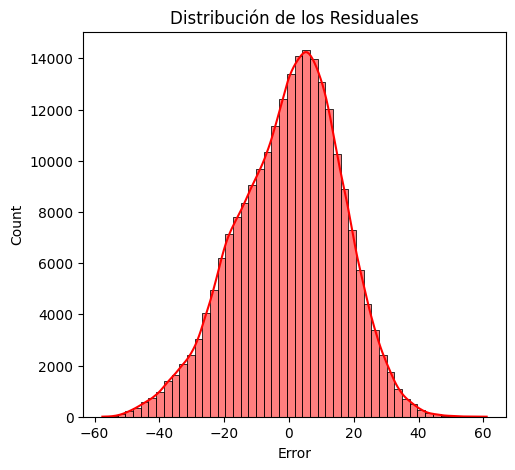

In [63]:
# Gráfica de distribución de residuales
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(modelo_robusto.resid, bins=50, kde=True, color='red')
plt.title('Distribución de los Residuales')
plt.xlabel('Error')

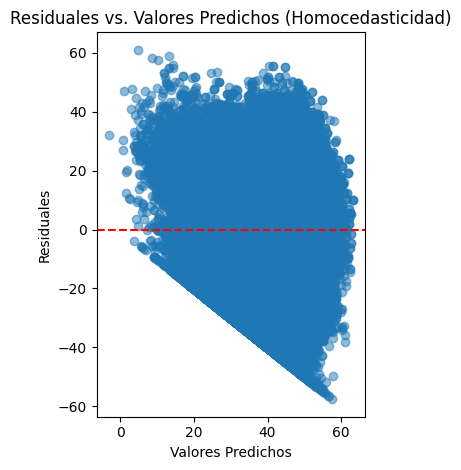

In [64]:
# Gráfica de Homocedasticidad (Residuales vs. Valores Predichos)
plt.subplot(1, 2, 2)
plt.scatter(modelo_robusto.fittedvalues, modelo_robusto.resid, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuales vs. Valores Predichos (Homocedasticidad)')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuales')
plt.tight_layout()
plt.show()